# Combatting Partisan Homogenization in New Content Recommenders - Baselines (GLOVE)

In [1]:
# to do
# test with our prototypes and our actual topic labelled data
# use immigration and guns topic, prototypes have to have differing stance variation

## Table of Contents 
### [Clustering Documents, Filtering and Vectorization](#Clustering_Documents_Filtering_Vectorization)
### [Baseline 1 - (Cluster Similarity vs Model Performance)](#Cluster_Similarity_vs_Model_Performance)
### [Baseline 2 - (Online Setting Performance)](#Online_Setting_Performance)
### [Baseline 3 - (Single Cluster Online Setting Performance)](#Single_Cluster_Online_Setting_Performance)
### [Baseline 4 - (Regularization vs Online Setting Performance)](#Regularization_vs_Online_Setting_Performance)
### [Baseline 5 - (Learning Rate vs Online Setting Performance)](#Learning_Rate_vs_Online_Setting_Performance)
### [Baseline 6 - (Online Setting Mixed Data Performance)](#Online_Setting_Mixed_Data_Performance)
### [Baseline 7 - (Learning Rate vs Online Setting Mixed Data Performance)](#Learning_Rate_vs_Online_Setting_Mixed_Data_Performance)

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [4]:
from general_utils import timer

from config import RANDOM_SEED

from bert_utils import load_bert_output

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction, vectorize_text

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from metrics_utils import calculate_avg_precision, calculate_map, get_scores, get_scores_wot, calculate_avg_precision_param_variation, calculate_map_param_variation

from model_utils import ( run_model, 
                         run_bs1_train_all, 
                         run_online_setting_active, 
                         run_bs2_train_all, 
                         run_bs3_train_all, 
                         run_bs4_train_all, 
                         run_bs5_train_all, 
                         run_bs6_train_all, 
                         run_bs7_train_all)

from plotters_baseline import ( plot_size_dist, 
                               bsl1_sim_vs_score_all_users, 
                               regularization_plot_helper, 
                               plot_regularization_vs_metrics_at_k, 
                               combine_scores_reg_vs_metrics_at_k, 
                               plot_regularization_vs_metrics_at_k_cumu, 
                               plot_lr_vs_metrics_at_k, 
                               plot_lr_vs_metrics_at_k_cumu, 
                               plot_online_setting_per_clusterpair, 
                               plot_helper_all_cp, 
                               plot_all_cp_online, 
                               plot_all_cp_singlecluster, 
                               plot_helper_scp, 
                               plot_single_cluster_performance, 
                               plot_mixed_data_all_cp_perf, 
                               plot_helper_md, 
                               plot_prec_sep, 
                               plot_mixed_data_performance_per_cluster, 
                               plot_mixed_data_performance, 
                               combine_scores_cumu_online_setting,
                               plot_mixed_cluster_cumulative, 
                               plot_online_learning_cumulative, 
                               plot_single_cluster_cumulative, 
                               plot_mixed_data_all_cp_perf, 
                               lr_mixed_plot_helper, 
                               plot_lr_vs_metrics_at_k_mixed, 
                               plot_mixed_data_all_cp_precis_lr, 
                               plot_mixed_cluster_cumulative_per_cluster  )   

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [5]:
warnings.filterwarnings('ignore')

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

## Clustering Documents, Filtering and Vectorization <a class="anchor" id="Clustering_Documents_Filtering_Vectorization"></a>

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4458 mins


Finished running 'sample_data' in 0.0014 mins

Sampled Size: 100000
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3118 mins

Completed - 10000
Completed - 20000
Completed - 30000
Completed - 40000
Completed - 50000
Completed - 60000
Completed - 70000
Completed - 80000
Completed - 90000
Number of Vectors : 100000
Dimension of Single Vector: (1, 300)

Finished running 'text_2_glove' in 23.0065 mins


Finished running 'vectorize_text' in 23.0087 min

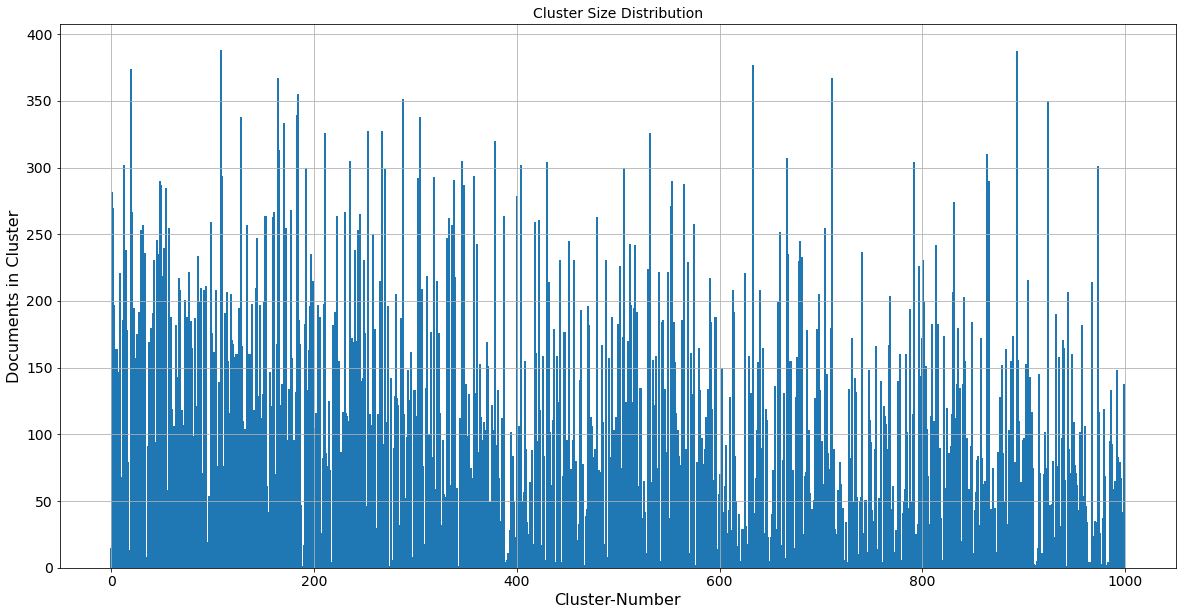


Finished running 'get_pairwise_dist' in 0.0000 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0005 mins

499500


In [7]:
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

vectors = vectorize_text(df=sampled_df,mode="glove")

reduced_vectors = vectors

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

In [8]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0005 mins



In [9]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=250,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.1009 mins

Filtered CLustered Pairs : 465


In [10]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0000 mins



## Baseline 1 : <a class="anchor" id="Cluster_Similarity_vs_Model_Performance"></a>

In [11]:
df_result = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.0070 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.0077 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0071 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0027 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0020 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.0024 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.0022 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.0023 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.0037 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0025 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.0030 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.0032 mins

Training model

In [12]:
df_result_homog = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.0035 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.0029 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0025 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0026 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0026 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.0024 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.0024 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.0027 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.0028 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0030 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.0025 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.0030 mins

Training model

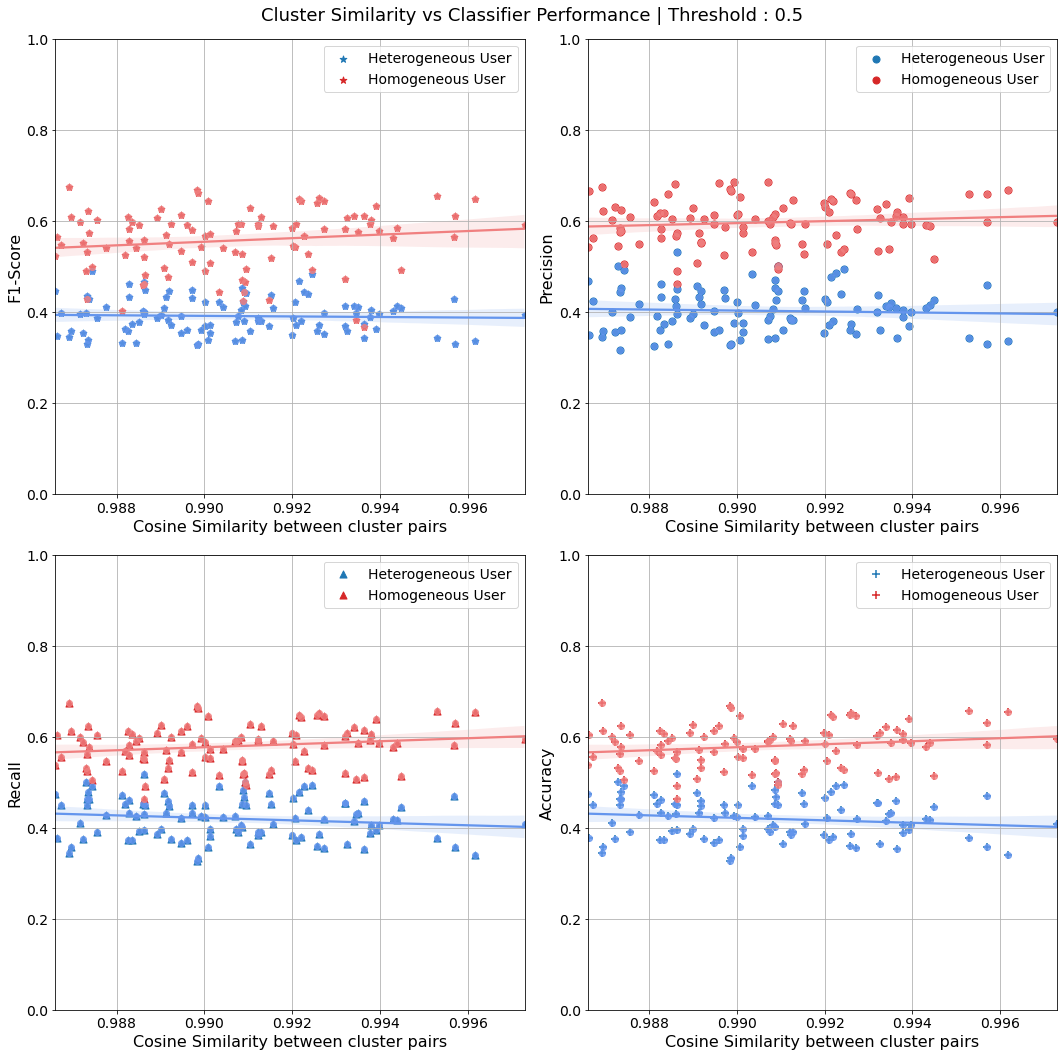


Finished running 'bsl1_sim_vs_score_all_users' in 0.0213 mins



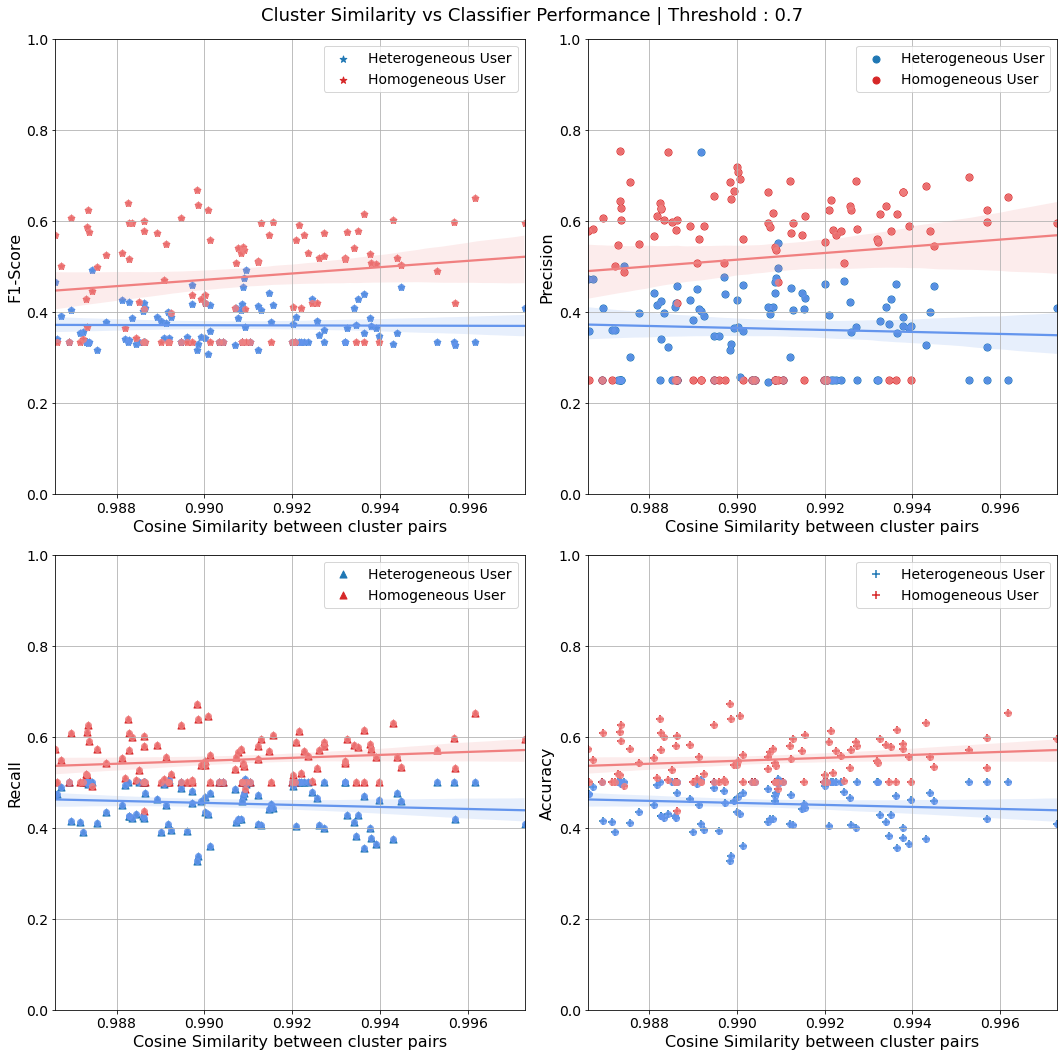


Finished running 'bsl1_sim_vs_score_all_users' in 0.0203 mins



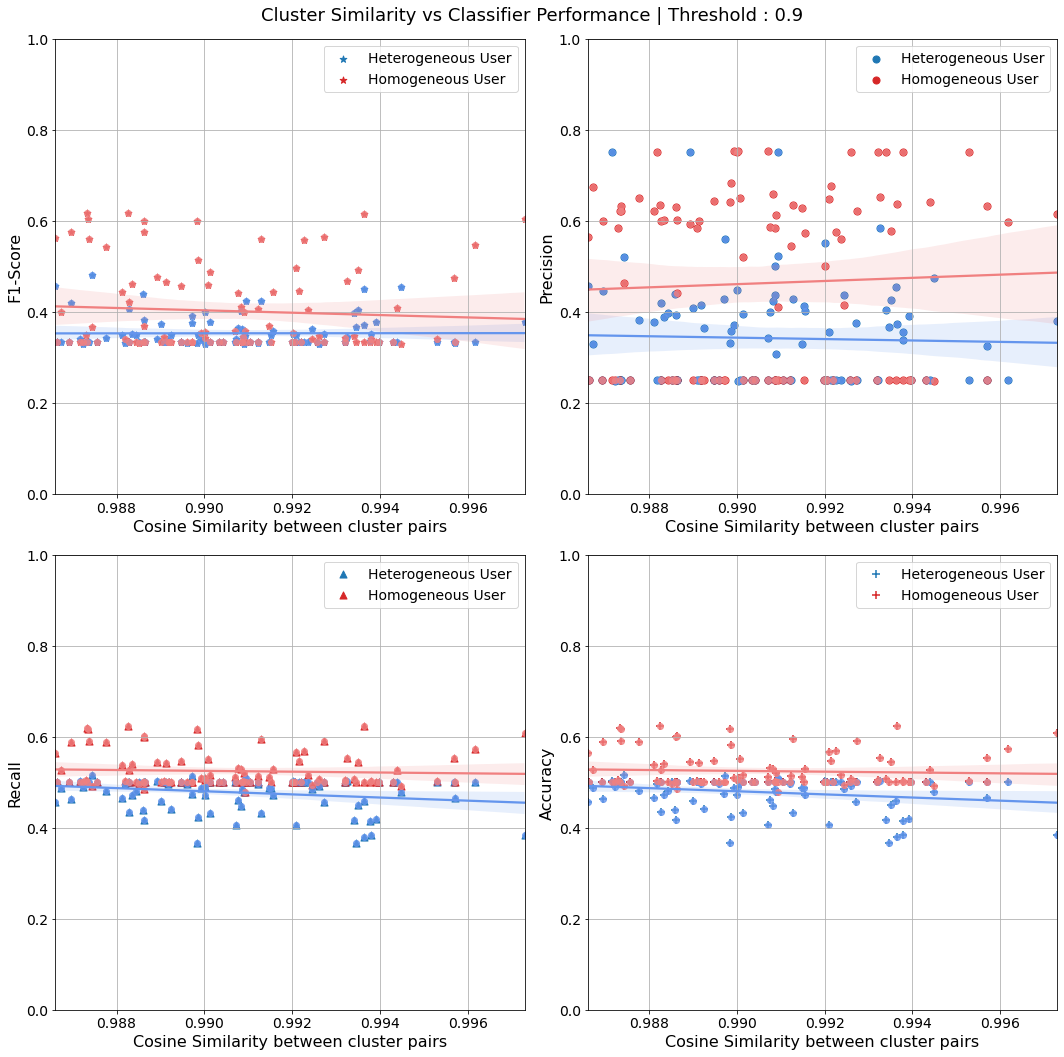


Finished running 'bsl1_sim_vs_score_all_users' in 0.0253 mins



In [13]:
for threshold in [0.5,0.7,0.9]:
    bsl1_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

<!-- ## Online Learning Setting - Active Learning Setting (Performance Measured on Held Out Validation Dataset) -->

## Baseline 2 : <a class="anchor" id="Online_Setting_Performance"></a>

In [14]:
hetero_scores,df_res_map_hetero = run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : (192, 430)
Training model for cluster pair : (893, 973)
Training model for cluster pair : (792, 831)
Training model for cluster pair : (243, 893)
Training model for cluster pair : (430, 893)
Training model for cluster pair : (479, 506)
Training model for cluster pair : (152, 358)
Training model for cluster pair : (49, 831)
Training model for cluster pair : (164, 893)
Training model for cluster pair : (711, 973)
Training model for cluster pair : (223, 553)
Training model for cluster pair : (378, 667)
Training model for cluster pair : (667, 893)
Training model for cluster pair : (243, 430)
Training model for cluster pair : (164, 924)
Training model for cluster pair : (164, 430)
Training model for cluster pair : (711, 893)
Training model for cluster pair : (48, 267)
Training model for cluster pair : (164, 243)
Training model for cluster pair : (506, 553)
Training model for cluster pair : (667, 711)
Training model for cluster pair : (223, 792)
Training mod

In [15]:
homo_scores, df_res_map_homo =  run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : (192, 430)
Training model for cluster pair : (893, 973)
Training model for cluster pair : (792, 831)
Training model for cluster pair : (243, 893)
Training model for cluster pair : (430, 893)
Training model for cluster pair : (479, 506)
Training model for cluster pair : (152, 358)
Training model for cluster pair : (49, 831)
Training model for cluster pair : (164, 893)
Training model for cluster pair : (711, 973)
Training model for cluster pair : (223, 553)
Training model for cluster pair : (378, 667)
Training model for cluster pair : (667, 893)
Training model for cluster pair : (243, 430)
Training model for cluster pair : (164, 924)
Training model for cluster pair : (164, 430)
Training model for cluster pair : (711, 893)
Training model for cluster pair : (48, 267)
Training model for cluster pair : (164, 243)
Training model for cluster pair : (506, 553)
Training model for cluster pair : (667, 711)
Training model for cluster pair : (223, 792)
Training mod

In [16]:
hetero_scores.keys()

dict_keys([(192, 430), (893, 973), (792, 831), (243, 893), (430, 893), (479, 506), (152, 358), (49, 831), (164, 893), (711, 973), (223, 553), (378, 667), (667, 893), (243, 430), (164, 924), (164, 430), (711, 893), (48, 267), (164, 243), (506, 553), (667, 711), (223, 792), (531, 893), (152, 973), (235, 924), (243, 667), (1, 924), (243, 973), (243, 711), (358, 973), (243, 267), (378, 711), (267, 667), (164, 711), (48, 160), (667, 924), (192, 893), (267, 711), (358, 893), (430, 973), (1, 711), (235, 711), (479, 553), (711, 924), (243, 924), (164, 831), (243, 378), (378, 479), (164, 553), (378, 893), (1, 479), (553, 924), (164, 378), (358, 531), (223, 506), (49, 164), (531, 973), (152, 893), (192, 973), (223, 831), (152, 243), (160, 667), (49, 792), (553, 831), (177, 506), (378, 924), (1, 235), (164, 667), (243, 553), (893, 924), (267, 893), (430, 711), (430, 924), (479, 711), (553, 792), (192, 243), (164, 192), (338, 792), (152, 866), (711, 866), (1, 378), (667, 973), (164, 973), (54, 711

In [17]:
# plot_online_setting_per_clusterpair(homo_scores[(423, 437)],hetero_scores[(423, 437)],single=True,active=False)


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



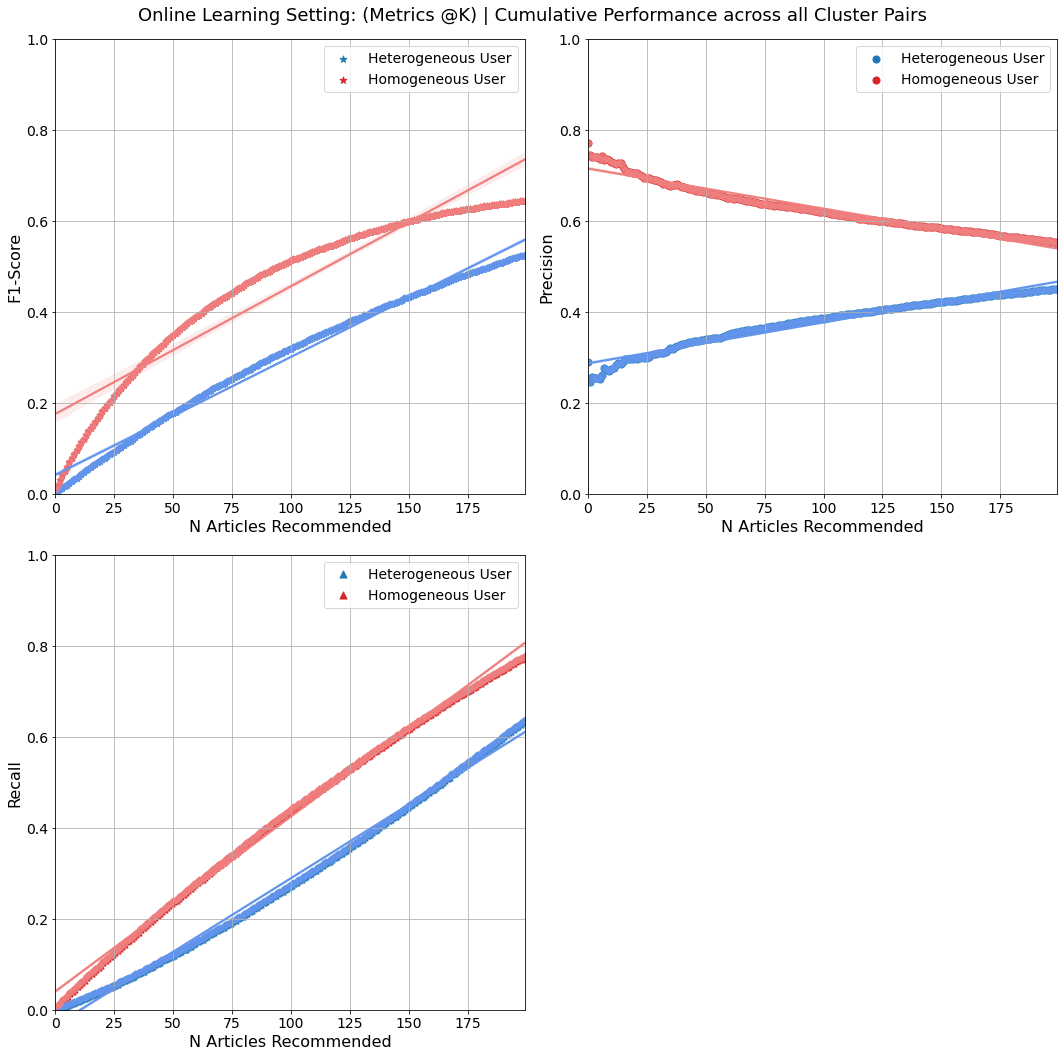


Finished running 'plot_online_setting_per_clusterpair' in 0.0174 mins


Finished running 'plot_online_learning_cumulative' in 0.0175 mins



In [18]:
plot_online_learning_cumulative(homo_scores,hetero_scores,active=False)

In [19]:
# homo_scores[(423, 437)].keys()

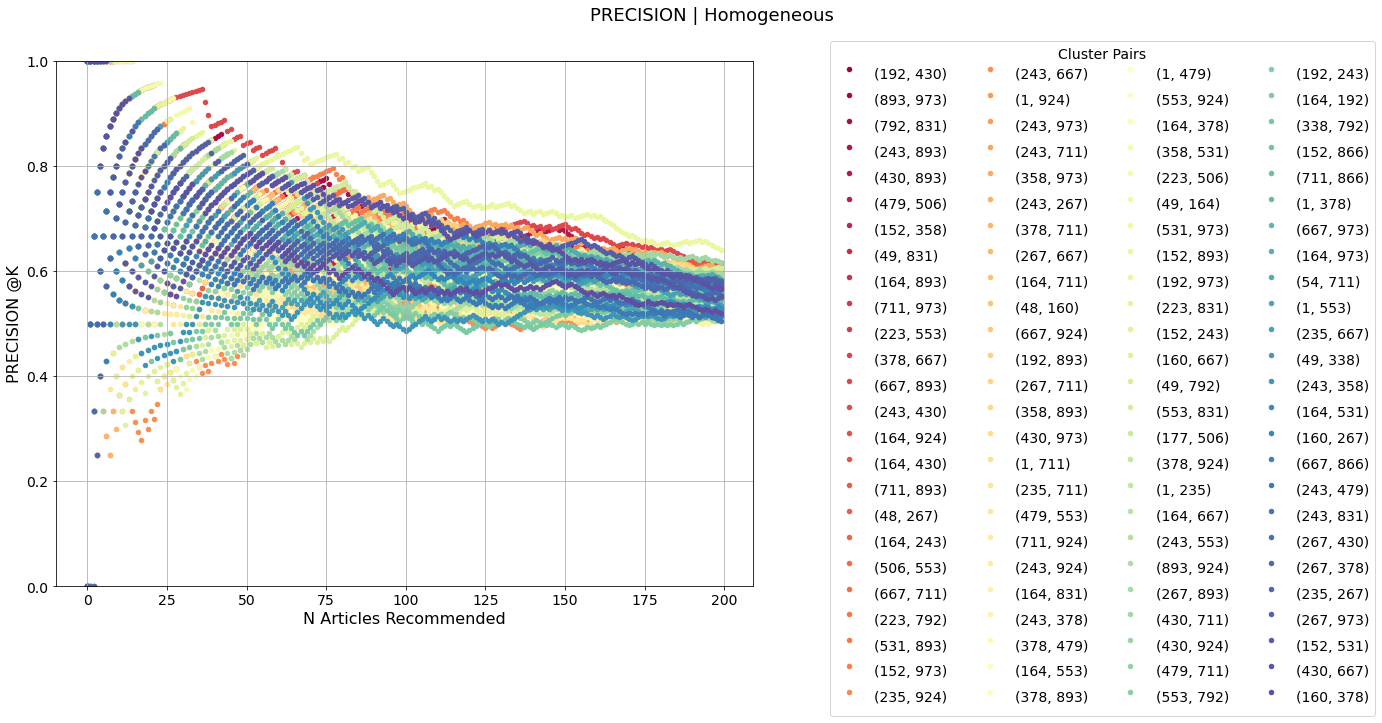


Finished running 'plot_all_cp_online' in 0.0612 mins



In [20]:
plot_all_cp_online(homo_scores,user_type="Homogeneous",metric="precision")

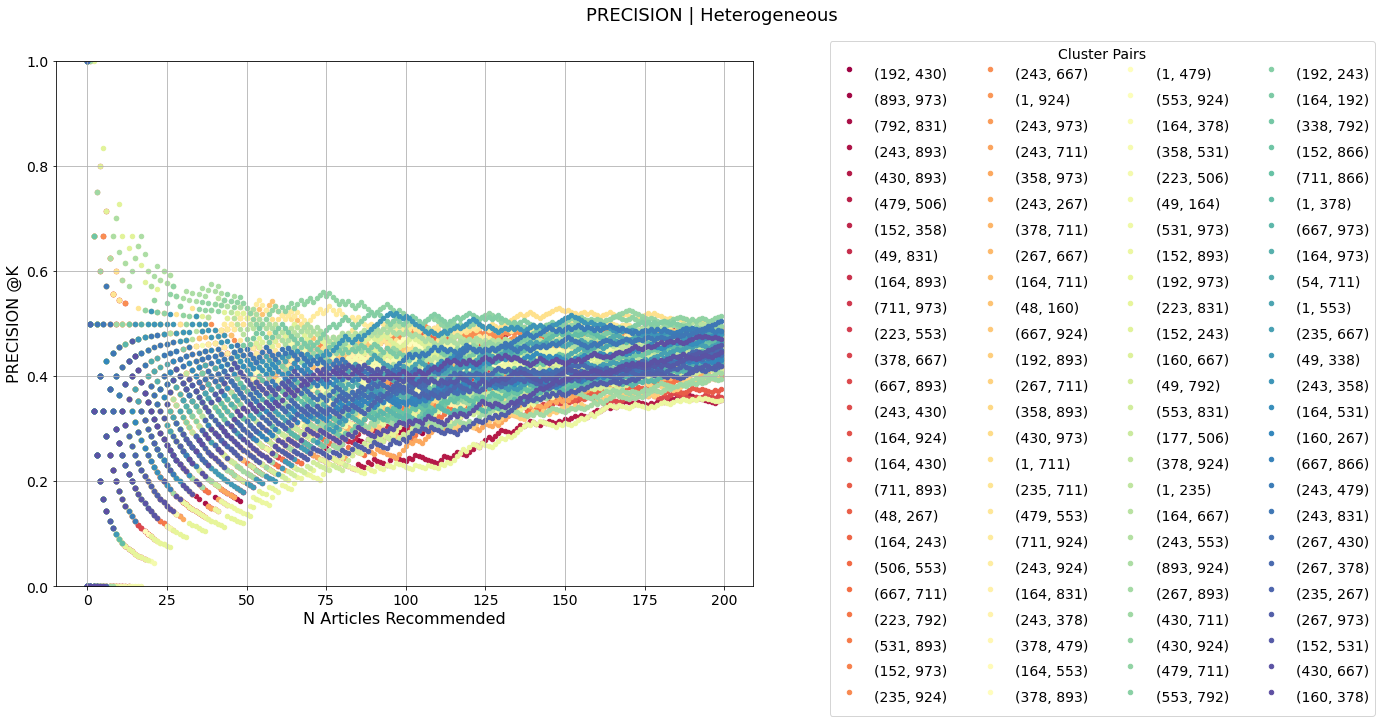


Finished running 'plot_all_cp_online' in 0.0612 mins



In [21]:
plot_all_cp_online(hetero_scores,user_type="Heterogeneous",metric="precision")

In [22]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [23]:
np.mean(avg_presc_homo)

0.6270520231484064

In [24]:
avg_presc_hetero = calculate_avg_precision(hetero_scores,mode="single")

In [25]:
np.mean(avg_presc_hetero)

0.37629727381120576

## Baseline 3 :  <a class="anchor" id="Single_Cluster_Online_Setting_Performance"></a>

In [26]:
hetero_scores = run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [27]:
homo_scores =  run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [28]:
# plot_single_cluster_performance(homo_scores[(585, 712)],hetero_scores[(585, 712)],single=True)


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



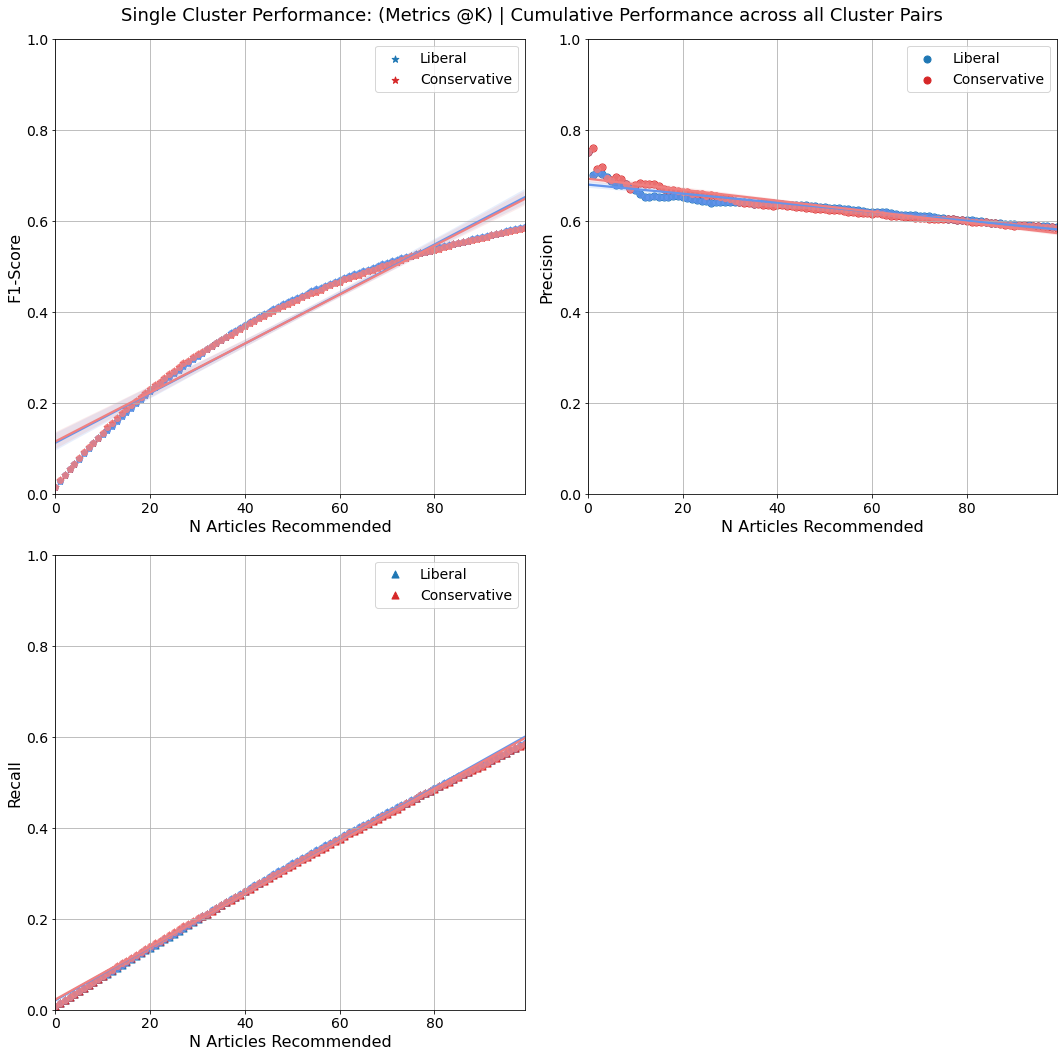


Finished running 'plot_single_cluster_performance' in 0.0159 mins


Finished running 'plot_single_cluster_cumulative' in 0.0159 mins



In [29]:
plot_single_cluster_cumulative(homo_scores,hetero_scores)

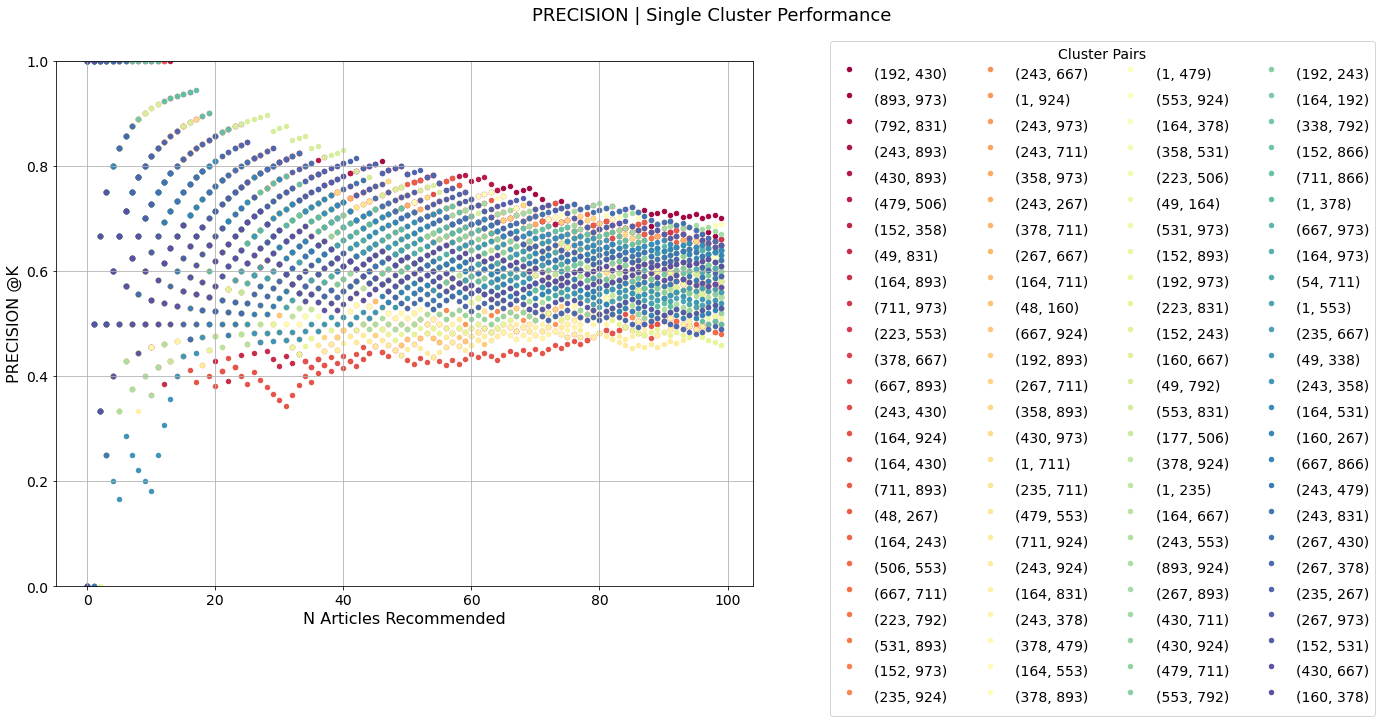


Finished running 'plot_all_cp_singlecluster' in 0.0557 mins



In [30]:
plot_all_cp_singlecluster(homo_scores)

In [31]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [32]:
np.mean(avg_presc_homo)

0.6326697706164388

## Baseline 4: <a class="anchor" id="Regularization_vs_Online_Setting_Performance"></a>

In [33]:
hetero_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [34]:
homo_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0002 mins



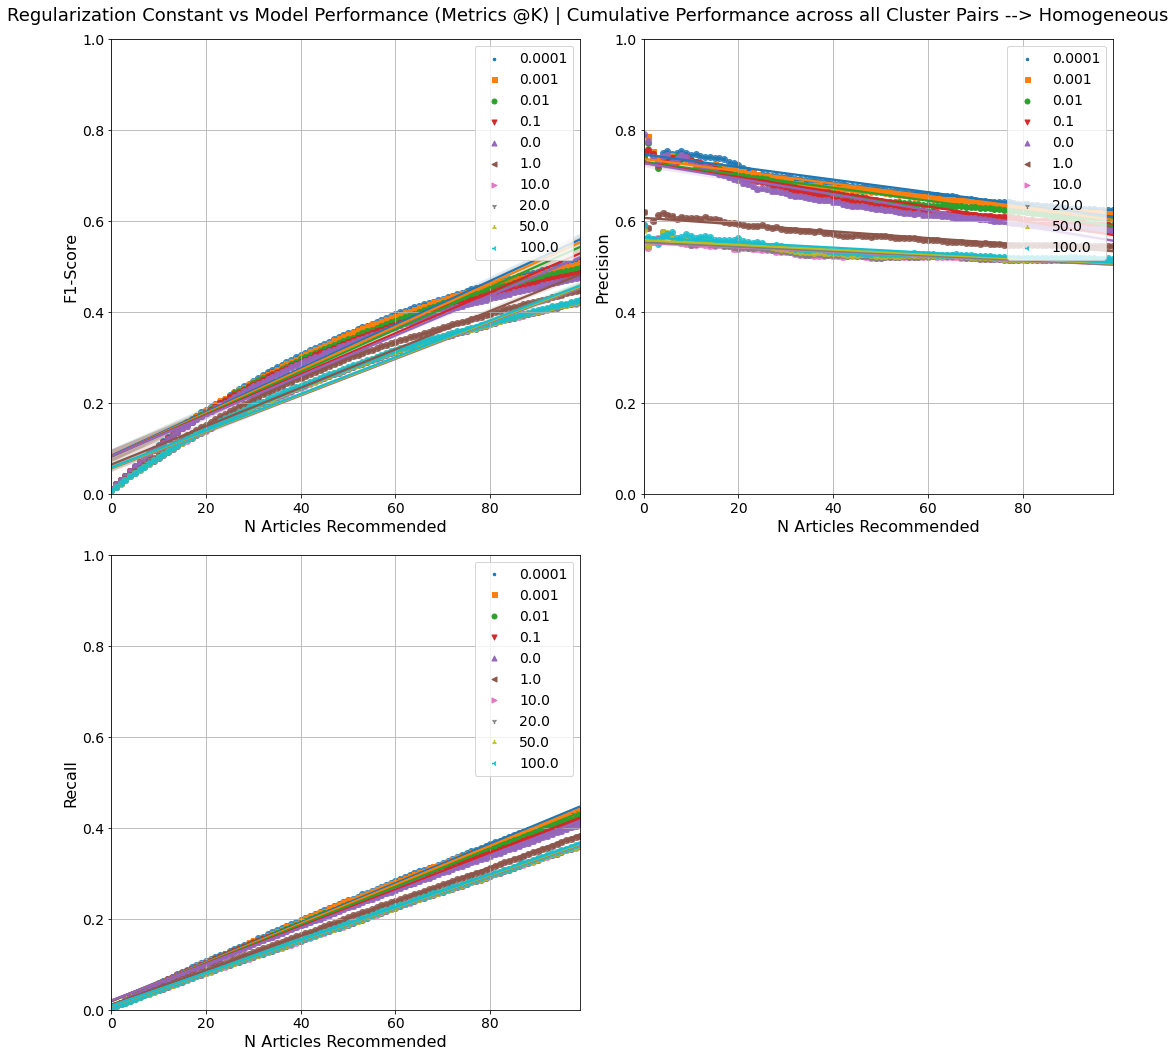


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0575 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0578 mins



In [35]:
plot_regularization_vs_metrics_at_k_cumu(homo_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0],
                                         user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0002 mins



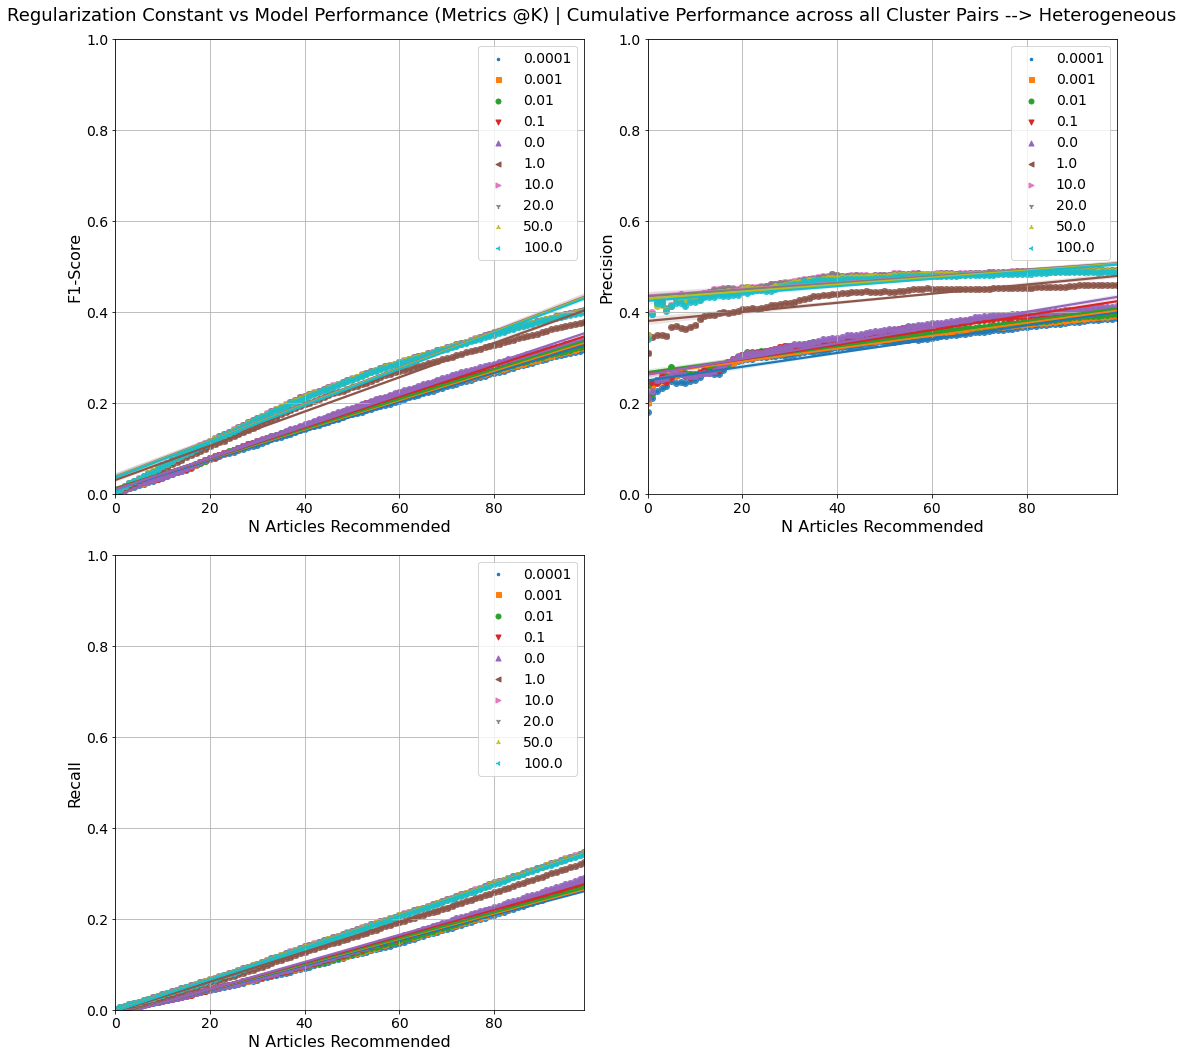


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0583 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0585 mins



In [36]:
plot_regularization_vs_metrics_at_k_cumu(hetero_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [37]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [38]:
calculate_map_param_variation(homo_param_res)


Param : 0.0001
0.6773211943946206

Param : 0.001
0.6688856762302321

Param : 0.01
0.6589335680201868

Param : 0.1
0.6482423607264616

Param : 0.0
0.6415670449293782

Param : 1.0
0.5698653008414971

Param : 10.0
0.5272626054308875

Param : 20.0
0.5284173563733013

Param : 50.0
0.53170156069553

Param : 100.0
0.535704260481964


In [39]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [40]:
calculate_map_param_variation(hetero_param_res)


Param : 0.0001
0.32408002675105535

Param : 0.001
0.3330347883616676

Param : 0.01
0.33738297076512397

Param : 0.1
0.34311422140134895

Param : 0.0
0.3474330551987741

Param : 1.0
0.42930904912596096

Param : 10.0
0.4710912100454932

Param : 20.0
0.47037638710781093

Param : 50.0
0.467186012126384

Param : 100.0
0.4638866976948481


## Baseline 5 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Performance"></a>

In [41]:
hetero_scores,df_het_res_100,df_het_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (192, 430) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (192, 430) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (192, 430) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (192, 430) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (192, 430) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (192, 430) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (192, 430) , LR = 20 *****

In [42]:
homo_scores,df_hom_res_100,df_hom_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (192, 430) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (192, 430) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (192, 430) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (192, 430) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (192, 430) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (192, 430) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (192, 430) , LR = 20 *****


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



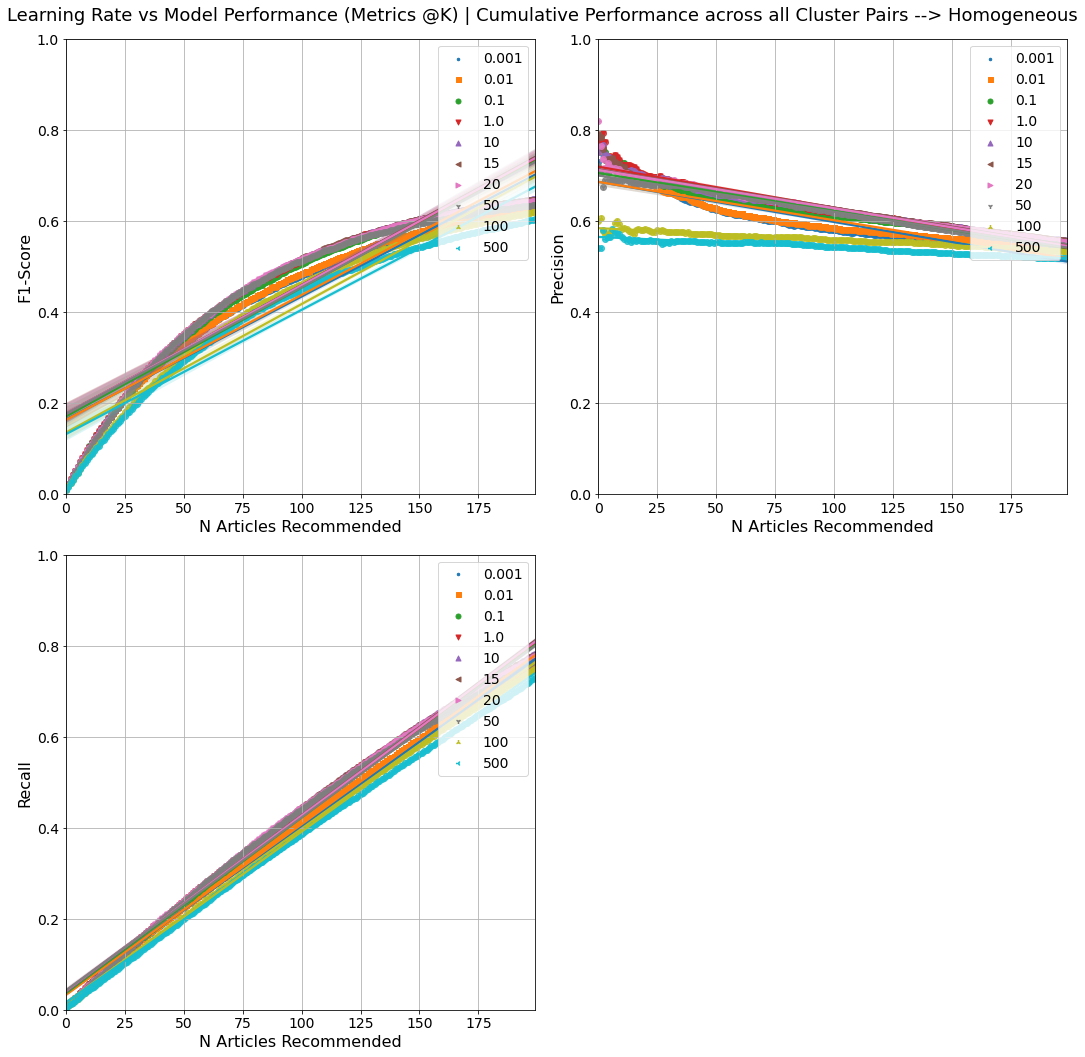


Finished running 'plot_lr_vs_metrics_at_k' in 0.0630 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0635 mins



In [43]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0004 mins



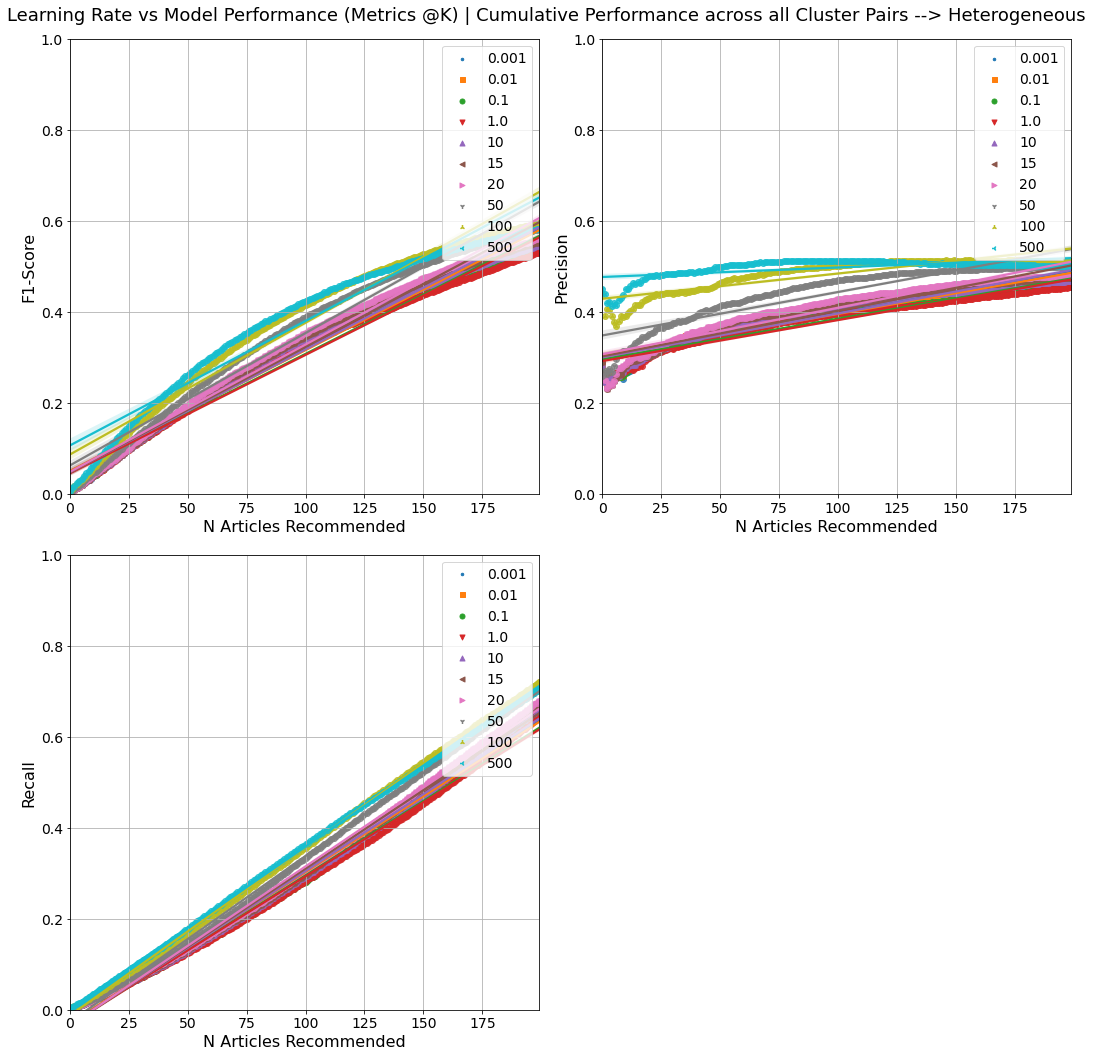


Finished running 'plot_lr_vs_metrics_at_k' in 0.0698 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0703 mins



In [44]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [45]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [46]:
calculate_map_param_variation(homo_param_res)


Param : 0.001
0.5978287268837642

Param : 0.01
0.6015127864710884

Param : 0.1
0.6220342049077776

Param : 1.0
0.6295470911725862

Param : 10
0.6289674482450409

Param : 15
0.6294614392653195

Param : 20
0.6280324357614704

Param : 50
0.6202719492857957

Param : 100
0.5586816200651209

Param : 500
0.541088033697126


In [47]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [48]:
calculate_map_param_variation(hetero_param_res)


Param : 0.001
0.3964372888802516

Param : 0.01
0.3948385465794816

Param : 0.1
0.384448060336606

Param : 1.0
0.38138028959018655

Param : 10
0.39581542712039564

Param : 15
0.4019704664966385

Param : 20
0.40837947310940825

Param : 50
0.4429696922054327

Param : 100
0.48381930808566936

Param : 500
0.49724087201756795


## Baseline 6: <a class="anchor" id="Online_Setting_Mixed_Data_Performance"></a>

In [49]:
hetero_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [50]:
homo_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [51]:
# homo_scores.keys()

In [52]:
# plot_mixed_data_performance_per_cluster(homo_scores[(585, 712)],hetero_scores[(585, 712)])


Finished running 'combine_scores_mixed_data' in 0.0002 mins


Finished running 'combine_scores_mixed_data' in 0.0002 mins



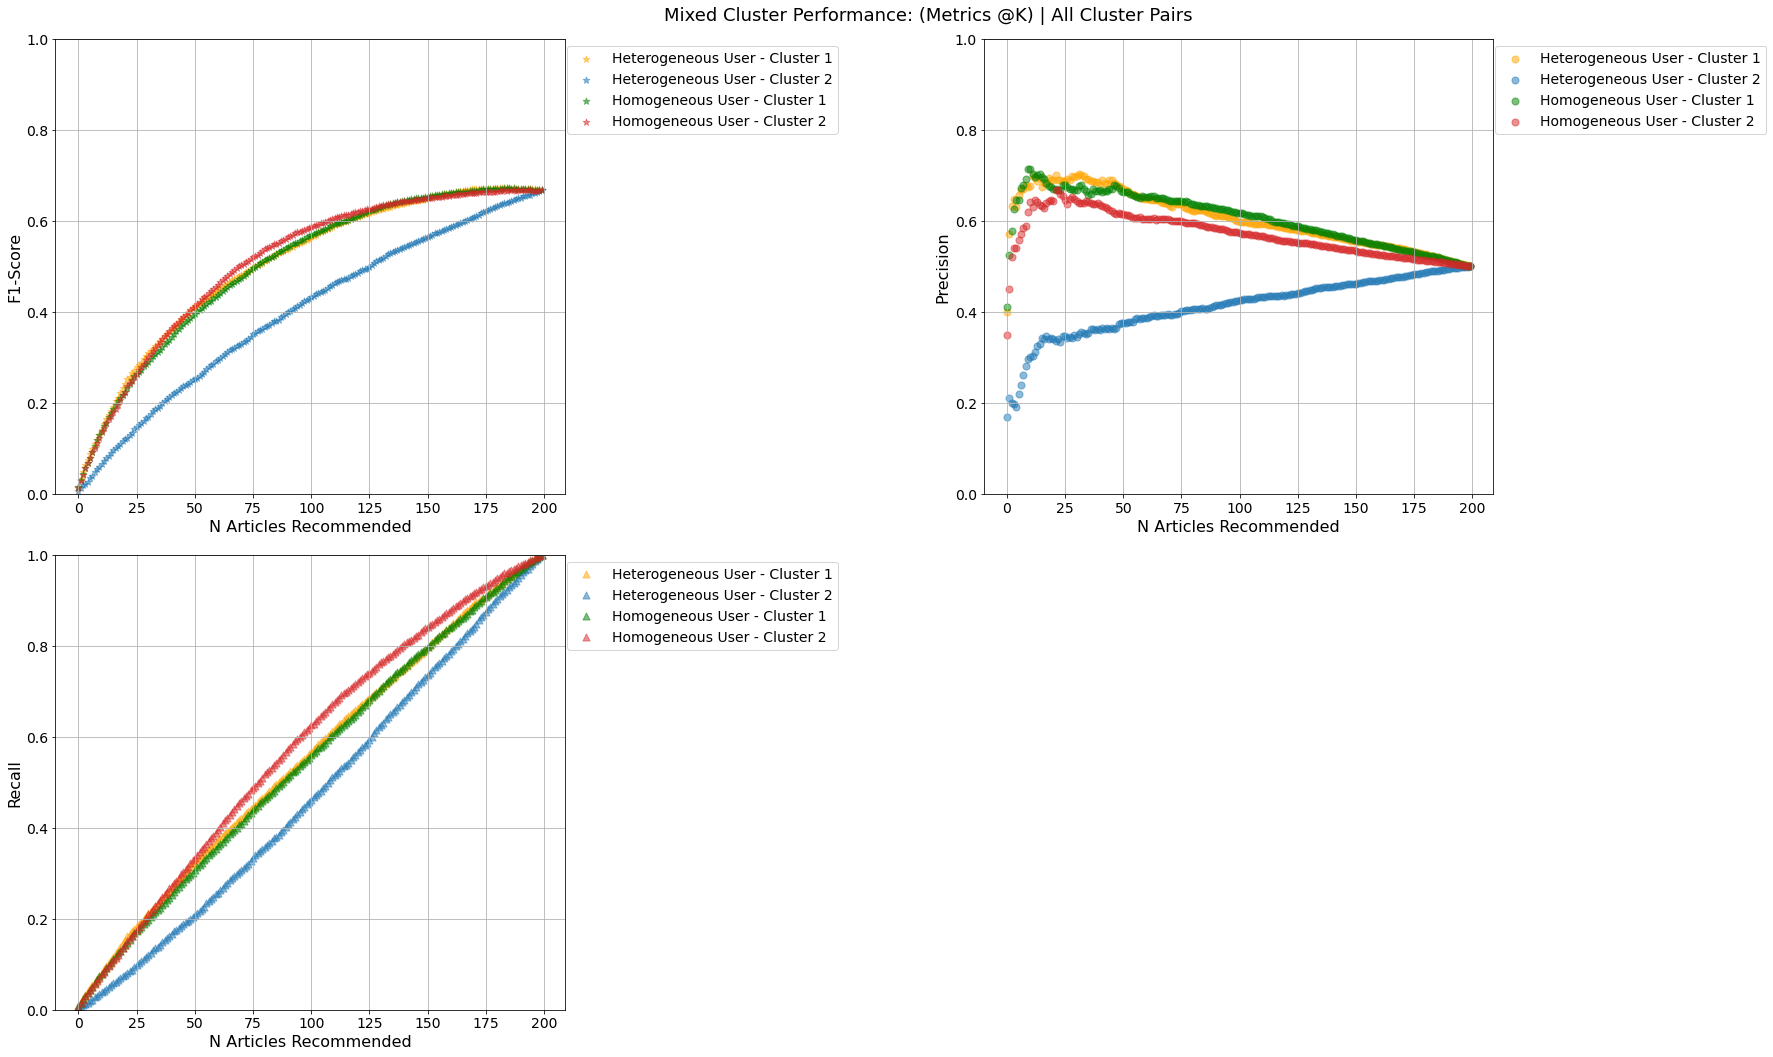


Finished running 'plot_mixed_data_performance_per_cluster' in 0.0103 mins


Finished running 'plot_mixed_cluster_cumulative_per_cluster' in 0.0107 mins



In [53]:
plot_mixed_cluster_cumulative_per_cluster(homo_scores,hetero_scores)

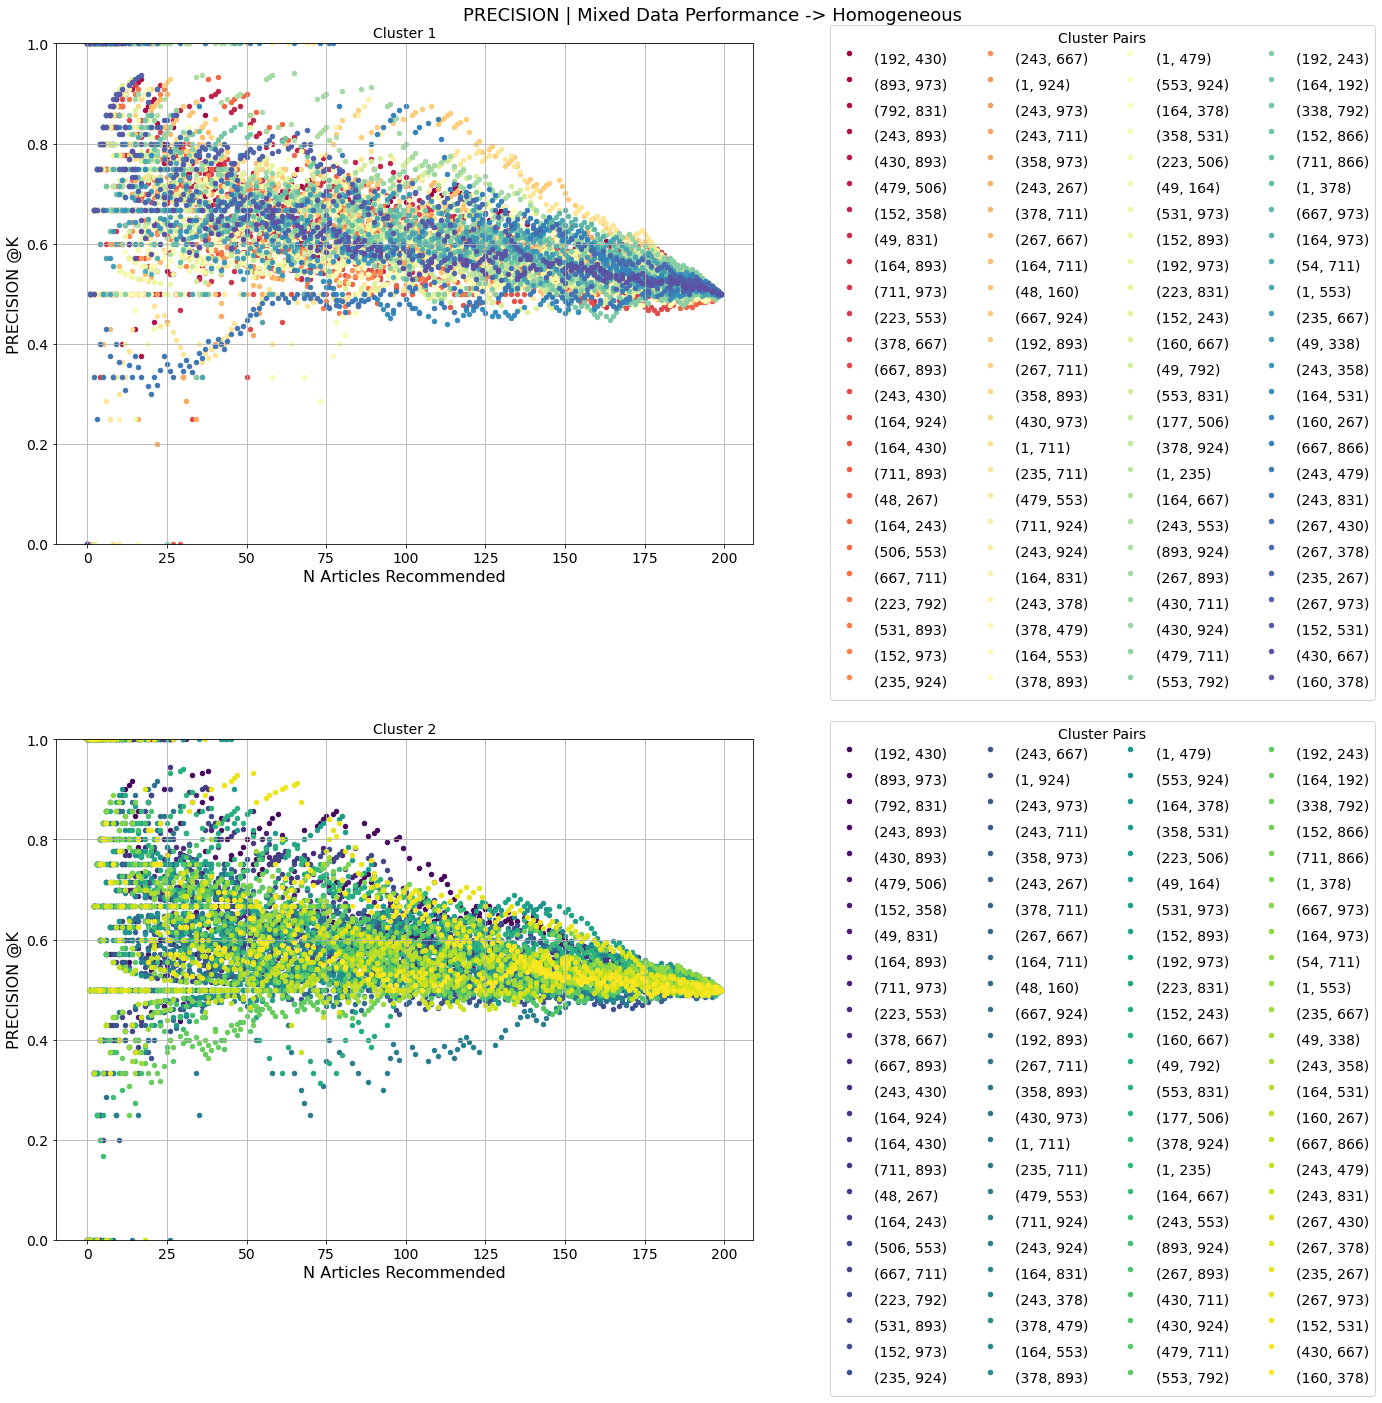


Finished running 'plot_mixed_data_all_cp_perf' in 0.1162 mins



In [54]:
plot_mixed_data_all_cp_perf(scores_cp=homo_scores,user_type="Homogeneous",metric="precision")

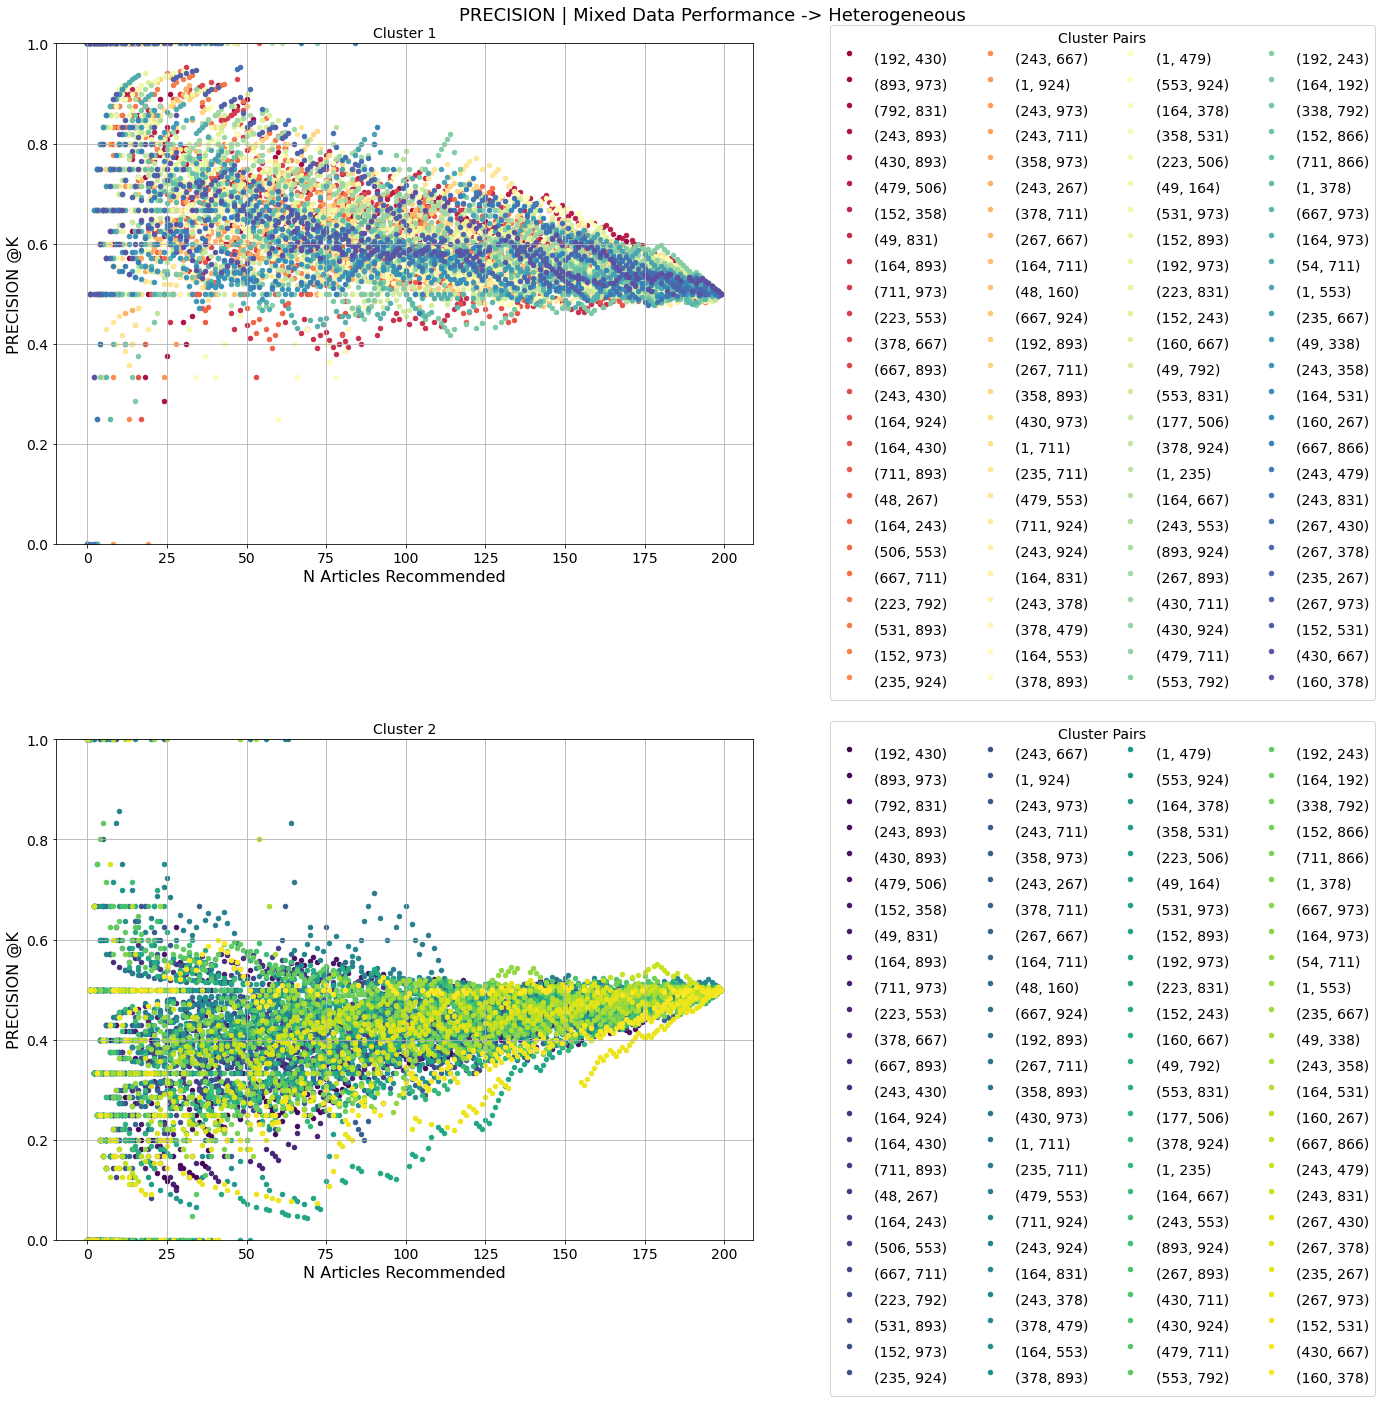


Finished running 'plot_mixed_data_all_cp_perf' in 0.1173 mins



In [55]:
plot_mixed_data_all_cp_perf(scores_cp=hetero_scores,user_type="Heterogeneous",metric="precision")

In [56]:
avg_presc_homo, avg_presc_homo_c1, avg_presc_homo_c2 = calculate_avg_precision(homo_scores,mode="mixed")

In [57]:
np.mean(avg_presc_homo)

0.5926861545717249

In [58]:
np.mean(avg_presc_homo_c1)

0.6059503183454884

In [59]:
np.mean(avg_presc_homo_c2)

0.5706171473983285

In [60]:
avg_presc_hetero,avg_presc_hetero_c1, avg_presc_hetero_c2 = calculate_avg_precision(hetero_scores,mode="mixed")

In [61]:
np.mean(avg_presc_hetero)

0.517034988027263

In [62]:
np.mean(avg_presc_hetero_c1)

0.6044223811867027

In [63]:
np.mean(avg_presc_hetero_c2)

0.41200839454046034

## Baseline 7 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Mixed_Data_Performance"></a>

In [64]:
hetero_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [65]:
homo_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [66]:
# plot_lr_vs_metrics_at_k_mixed(homo_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],user_type="Homogeneous")

In [67]:
# plot_lr_vs_metrics_at_k_mixed(hetero_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0007 mins



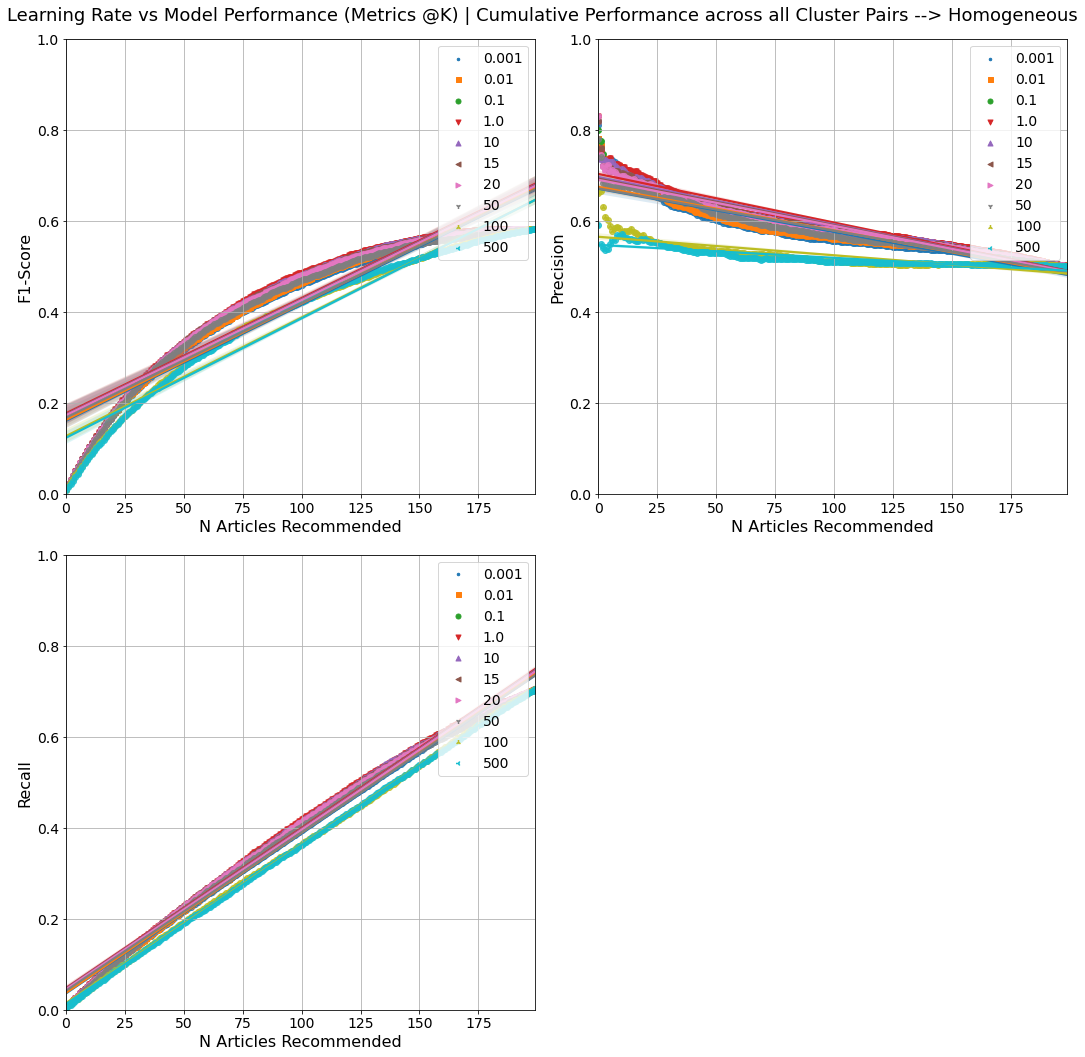


Finished running 'plot_lr_vs_metrics_at_k' in 0.0635 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0643 mins



In [68]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous",mixed_data=True)


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



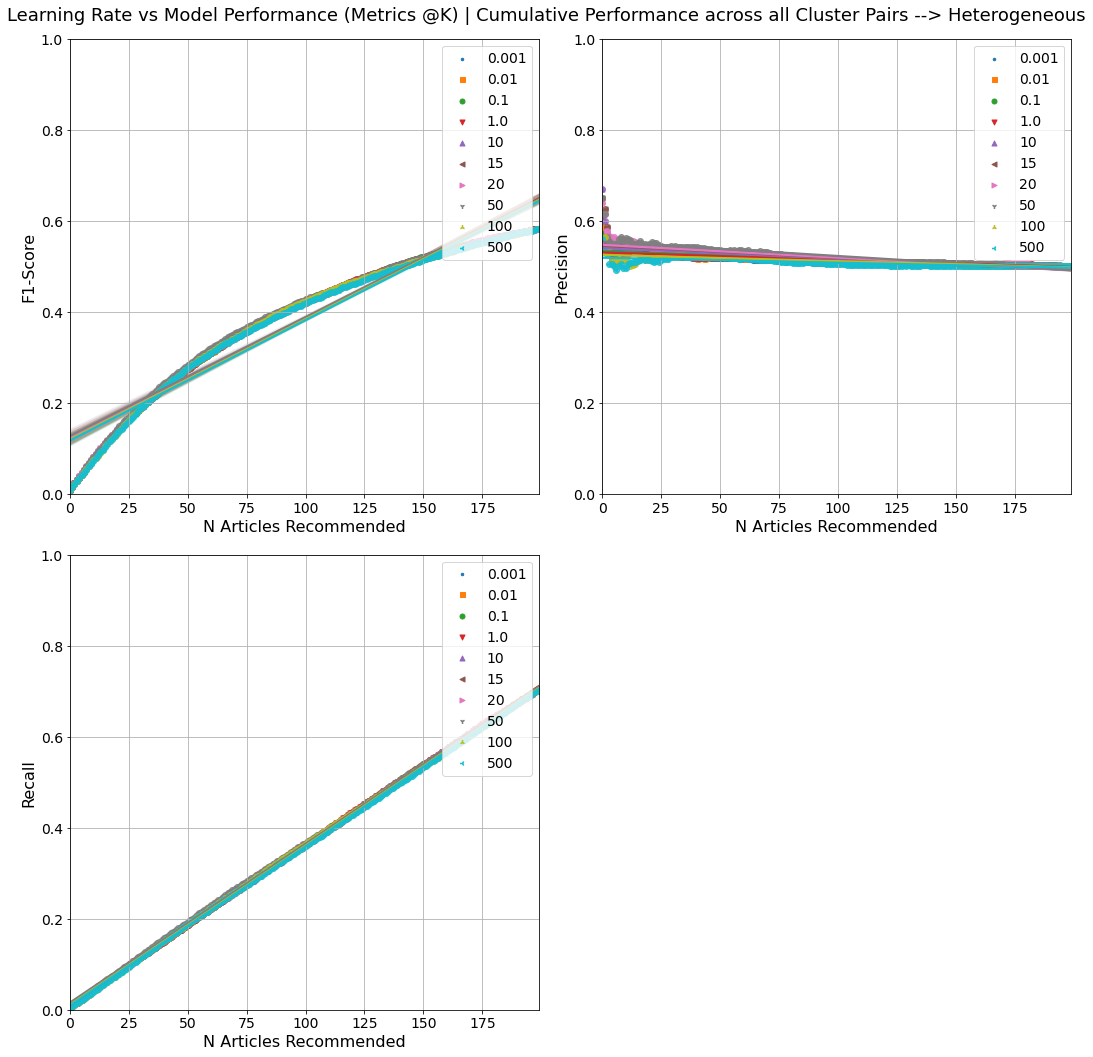


Finished running 'plot_lr_vs_metrics_at_k' in 0.0632 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0638 mins



In [69]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mixed_data=True)

In [70]:
#  plot_mixed_data_all_cp_precis_lr(scores_=homo_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Homogeneous",metric="precision")

In [71]:
#  plot_mixed_data_all_cp_precis_lr(scores_=hetero_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Heterogeneous",metric="precision")

In [72]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [73]:
calculate_map_param_variation(homo_param_res,mode="mixed")


Param : 0.001
0.575726369566713
c1 MAP : 
0.5856201538160815
c2 MAP : 
0.5622898810172053

Param : 0.01
0.5792907389929527
c1 MAP : 
0.5848593538895039
c2 MAP : 
0.5650898221981087

Param : 0.1
0.5920428656358115
c1 MAP : 
0.6005110036255034
c2 MAP : 
0.5736557779215086

Param : 1.0
0.5965535250825569
c1 MAP : 
0.6024355632570828
c2 MAP : 
0.5780917997643001

Param : 10
0.5927568371279738
c1 MAP : 
0.5970392672841449
c2 MAP : 
0.5808541196753058

Param : 15
0.5909680103499099
c1 MAP : 
0.5974645530597588
c2 MAP : 
0.5785984092618723

Param : 20
0.5893800594468768
c1 MAP : 
0.5964341807954513
c2 MAP : 
0.5786848233398868

Param : 50
0.5786755339353933
c1 MAP : 
0.5768300056785702
c2 MAP : 
0.5704456206823325

Param : 100
0.5243771476066984
c1 MAP : 
0.5215734812376085
c2 MAP : 
0.499498515763966

Param : 500
0.5187402292098168
c1 MAP : 
0.5125912363019816
c2 MAP : 
0.5075965339515615


In [74]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [75]:
calculate_map_param_variation(hetero_param_res,mode="mixed")


Param : 0.001
0.513210718219067
c1 MAP : 
0.5825324134484149
c2 MAP : 
0.40201684306769325

Param : 0.01
0.5128739643981192
c1 MAP : 
0.5834866129165602
c2 MAP : 
0.404407915831068

Param : 0.1
0.5148525749005946
c1 MAP : 
0.5928460584189821
c2 MAP : 
0.406403042600532

Param : 1.0
0.5143776463179693
c1 MAP : 
0.5967860086450212
c2 MAP : 
0.4063204073463001

Param : 10
0.5167889294531266
c1 MAP : 
0.5924414730644402
c2 MAP : 
0.403369520699153

Param : 15
0.5184280923938426
c1 MAP : 
0.5901430514588699
c2 MAP : 
0.4017853505157902

Param : 20
0.5190726236988049
c1 MAP : 
0.5888197347989265
c2 MAP : 
0.4025020230821992

Param : 50
0.5227248811533918
c1 MAP : 
0.5712272775096737
c2 MAP : 
0.41827271579544745

Param : 100
0.5113746522294368
c1 MAP : 
0.5226997121856328
c2 MAP : 
0.48292823152370273

Param : 500
0.507880613587022
c1 MAP : 
0.5076095390491878
c2 MAP : 
0.48709957097834605
